# Navier-Stokes with a pivot-fixed falling flat plate 
## Using `Whirl` and `Dyn3d`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

In [3]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


### Build joint-body chain

In [4]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints, 
                                   config_system)
bd = BodyDyn(bodys, joints, system)

### Initialize rigid body system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs))

nothing

This is a 1 body-joint system.
System is fixed in space


### Set up HERKBody object

In [6]:
herkbody = Dyn3d.HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


Genrate body grid points and get linear velocity on in

In [7]:
# generate body points and fit it into 2d, which each items choose [1,3] for 2d cases in [x,y]
bgs = GenerateBodyGrid(bd; np=201)
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

# generate the format for fluid interface
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]];

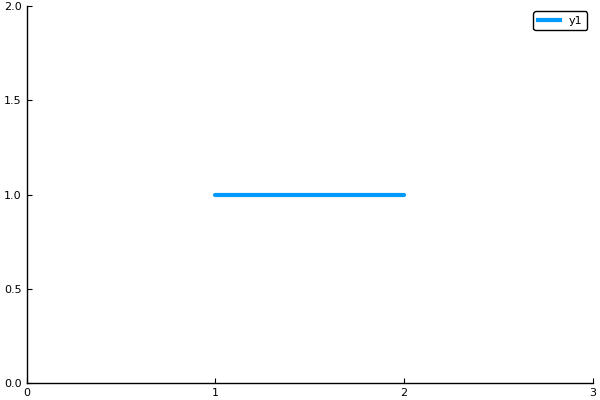

In [8]:
v = isdefined(:plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)
p = plot(vs[1][1,:,1],vs[1][1,:,2], linewidth=3, aspect_ratio=:equal)        
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid solver with Whirl </span>

Set the flow parameters

In [9]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the domain size and time step size

In [10]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

### Now start constructing operators

#### Set up the state vector and constraint force vector for a moving body

In [11]:
X̃ = VectorData(coord)
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

In [12]:
t = 0.0
w₀ .= 0.0
tf = 0.01
T = Δt:Δt:tf
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02

f = (VectorData(X̃),Vector{Float64}())

(51 points of vector-valued data
, Float64[])

In [13]:
function DeVectorData(f::VectorData)
    return hcat(f.u,f.v)
end

DeVectorData (generic function with 1 method)

## <span style="color:blue"> Prepare interface for fluid-body coupling </span>

Convert fluid force from VectorData format to Array{Float64,2}

In [14]:
# for i = 1:bgs[1].np
#     bgs[1].f_ex3d[i][1] = DeVectorData(f[1])[i,1]
#     bgs[1].f_ex3d[i][3] = DeVectorData(f[1])[i,2]    
# end

# bgs = IntegrateBodyGridDynamics(bd,bgs)

# f_exi = zeros(bd.sys.nbody,6)
# for i = 1:bd.sys.nbody
#     f_exi[i,:] = bgs[i].f_ex6d
# end
# f_exi

## <span style="color:blue"> Time Marching! </span>

Body Time marching

In [15]:
# herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
#                 (HERKFuncf,HERKFuncgti),
#                 (UpdatePosition!,UpdateVelocity!))
# soln, bd = herkbody(soln, bd; _isfixedstep=true, f_exi=f_exi);

Acquire motion and coord at this time for fluid

In [16]:
# bgs = AcquireBodyGridKinematics(bd,bgs)

# motion = hcat(bgs[1].v_i...)'[:,[1,2]]
# coord = hcat(bgs[1].q_i...)'[:,[1,2]];

Create Fluid solver object of type IFHERK

In [17]:
# u = (w₀,[coord motion][:])
# nc = length(u[2])

# # uniform constant free stream
# ifherk = Whirl.IFHERK(u,f,sys.Δt,
#                 ((t,u) -> Systems.plan_intfact(t,u,sys),
#                  (t,u) -> eye(nc)),
#                 (u,t) -> Whirl.plan_constraints(u,t,sys),
#                 ((u,t) -> Whirl.r₁(u,t,sys),
#                  (u,t) -> Whirl.r₂(u,t,sys)),
#                 tol=1e-3,rk=Whirl.TimeMarching.RK31,
#                 isstored=true,isstaticconstraints=false)

Fluid Time Marching

In [18]:
# t, u, f = ifherk(t,u)

# push!(thist,t)
# push!(fx,sum(f[1].u)*Δx^2)
# push!(fy,sum(f[1].v)*Δx^2)
# push!(uhist,u)

## Now put everything in a loop for one timestep

In [19]:
# construct body solver
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


In [20]:
u = (w₀,[coord motion][:])
nc = length(u[2])

# construct fluid solver
# uniform constant free stream
ifherk = Whirl.IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(nc)),
                (u,t) -> Whirl.plan_constraints(u,t,sys),
                ((u,t) -> Whirl.r₁(u,t,sys),
                 (u,t) -> Whirl.r₂(u,t,sys)),
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{51},Array{Float64,1}}
   Time step size 0.01


In [21]:
import Base:+
function (+)(a::VectorData, b::VectorData)
    c = VectorData(a)
    c.u .= a.u .+ b.u
    c.v .= a.v .+ b.v
    return c
end

+ (generic function with 241 methods)

In [22]:
import Base:*
function (*)(ω::Float64, a::VectorData)
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end
function (*)(a::VectorData,ω::Float64)
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end

* (generic function with 287 methods)

In [23]:
# typeof(f[1]*Δx^2)

In [24]:
# (1-ω)*fᵢ + ω*f[1]*Δx^2

In [ ]:
tol = 1e-3
soln.dt = Δt
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)
cnt = 1
fᵢ = f[1]

# record body info
soln_buffer = deepcopy(soln)
bd_buffer = deepcopy(bd)
bgs_buffer = deepcopy(bgs)

# record fluid info
u_buffer = deepcopy(u)
t_buffer = t

while true

    # retain previous body state
    soln = deepcopy(soln_buffer)
    bd = deepcopy(bd_buffer)
    bgs = deepcopy(bgs_buffer)

    # integrate body force for body solver
    for i = 1:bgs[1].np
        bgs[1].f_ex3d[i][1] = DeVectorData(fᵢ)[i,1]
        bgs[1].f_ex3d[i][3] = DeVectorData(fᵢ)[i,2]
    end
    bgs = IntegrateBodyGridDynamics(bd,bgs)
    f_exi = zeros(bd.sys.nbody,6)
    for i = 1:bd.sys.nbody
        f_exi[i,:] = bgs[i].f_ex6d
    end

    # advance body solver for one step
    soln, bd = herkbody(soln, bd; _isfixedstep=true, f_exi=f_exi);

    # acquire vel and coord of body points for fluid computation
    bgs = AcquireBodyGridKinematics(bd,bgs)
    coord = hcat(bgs[1].q_i...)'[:,[1,2]]
    motion = hcat(bgs[1].v_i...)'[:,[1,2]]

    # retain previous fluid state
    u = deepcopy(u_buffer)
    t = t_buffer

    # advance fluid solver for one step
    u = (u[1],[coord motion][:])
    t, u, f = ifherk(t,u)

    # check if converge
    ϵ = norm(f[1] - fᵢ)
    if ϵ < tol
        break
    end

    # if not converge, use relaxation
    fᵢ = (1-ω)*fᵢ + ω*f[1]*Δx^2

    # loop count
    print("count ",cnt,", ϵ = ",ϵ,"\n")
    cnt += 1

end

count 1, ϵ = 1542.83642616112
count 2, ϵ = 1571.4460898237817
count 3, ϵ = 1608.2946194713627
count 4, ϵ = 1650.15671771381
count 5, ϵ = 1694.6149814247542
count 6, ϵ = 1739.9173168509433
count 7, ϵ = 1784.8313849671742
count 8, ϵ = 1828.5174147155487


In [ ]:
# converged for this timestep

# record body info
push!(solns, soln)
push!(vs, VertsHistory(system.nbody, bd.bs))

# record fluid info
push!(thist,t)
push!(fx,sum(f[1].u)*Δx^2)
push!(fy,sum(f[1].v)*Δx^2)
(isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,u) : nothing

In [ ]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    # save data for later use
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

In [ ]:
uhist

In [ ]:
plot(xg,yg,uhist[1][1],levels=linspace(-0.25,0.25,30))
Tr = RigidTransform(uhist[1][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

In [ ]:
px = plot(thist,2*fx,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [ ]:
ψ = deepcopy(u[1])
ψ .= -(sys.L\u[1])*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)